# Quantum benchmark

## I - Introduction

## II - Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import normalize
from sklearn.model_selection import cross_val_score, KFold
#Import classical libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import datasets
import matplotlib.pyplot as plt
from skpp import ProjectionPursuitRegressor

plt.style.use('ggplot')

import functools

from qiskit import BasicAer
from qiskit.circuit.library import ZZFeatureMap
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.datasets import ad_hoc_data
import logging

import pennylane as qml
from pennylane.templates.embeddings import AngleEmbedding, AmplitudeEmbedding
from pennylane.optimize import AdamOptimizer

from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal, ZZFeatureMap
import qiskit

In [2]:
import warnings
warnings.filterwarnings('ignore')

## III - Data 

In [3]:
# Read out CSV

df = pd.read_csv('UCI_Credit_Card.csv', sep=',')

In [4]:
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default.payment.next.month'],
      dtype='object')

In [9]:
df.shape

(20468, 114)

In [10]:
%%script false --no-raise-error

import sweetviz as sv

#EDA using Autoviz
sweet_report = sv.analyze(df)

#Saving results to HTML file
sweet_report.show_html('sweet_report.html')

## IV - Modelisation

### Classical

In [5]:
df_labels = df['default.payment.next.month']
df.drop(['default.payment.next.month'],axis = 1,inplace = True)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df, df_labels, test_size=0.2, random_state=42)

## Quantum Approaches

In [13]:
np.unique(df_labels)

array([0, 1])

In [16]:
np.shape(X_train)

(16374, 93)

In [7]:
skpp = ProjectionPursuitRegressor(r=2, fit_type='spline', opt_level='medium').fit(X_train, y_train)

In [8]:
# SKPP validate transformation (using train fit)
x_train_skpp = skpp.transform(X_train)
x_test_skpp = skpp.transform(X_test)

In [9]:
# Arrays to dataframe for join in a single df
x_train_skpp = pd.DataFrame(x_train_skpp)
x_test_skpp = pd.DataFrame(x_test_skpp)

In [10]:
# Second standard scaler normalization (using train fit)
std_scale = StandardScaler().fit(x_train_skpp)
X_train_skpp_norm = std_scale.transform(x_train_skpp)
x_test_skpp_norn = std_scale.transform(x_test_skpp)
#x_validate_lda_n = std_scale.transform(x_validate_skpp)

In [11]:
# Dimensions definition for QML
n_dim = len(x_train_skpp.columns)
n_dim

2

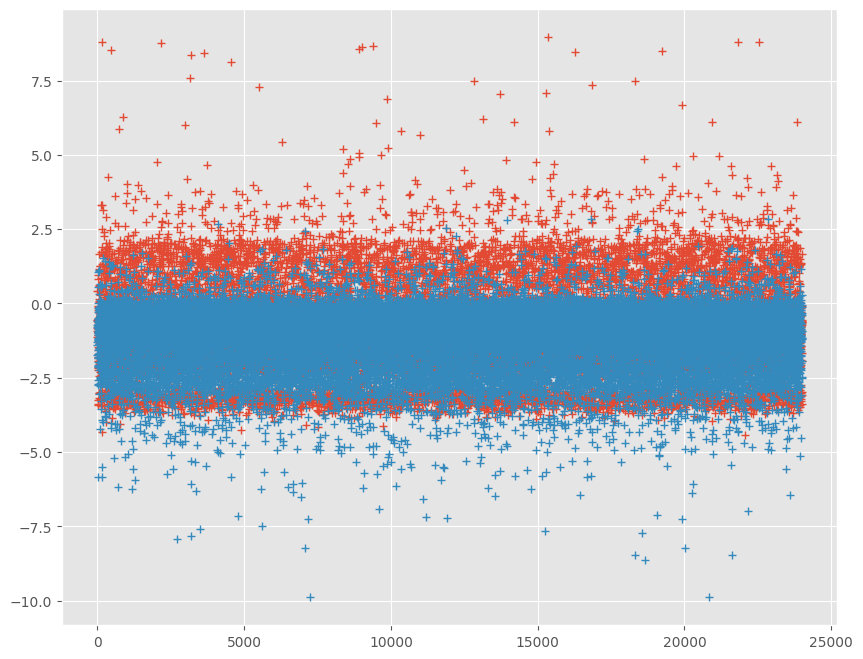

In [12]:
plt.figure(figsize=(10,8))
plt.plot(x_train_skpp, '+')


## Split train test 

In [13]:
# Split dataset into train and test

sample_train, sample_test, label_train, label_test = train_test_split(
     X_train_skpp_norm, y_train, test_size=0.2, random_state=22)

# Normalize

# Select a sample for a better control of the research and wall time

train_size = 800#160
sample_train = sample_train[:train_size]
label_train = label_train[:train_size]

test_size = 200 #40
sample_test = sample_test[:test_size]
label_test = label_test[:test_size]

In [14]:
# Basic parameters for hybrid model

seed = 8500
feature_dim = n_dim
num_reps = 2
num_shots =256 


## Hybrid

In [22]:
# Define feature_map

feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=num_reps)

# Define the backend
backend = QuantumInstance(
    BasicAer.get_backend("qasm_simulator"), shots=num_shots, seed_simulator=seed, seed_transpiler=seed
)

# Define the kernel

kernel = QuantumKernel(feature_map=feature_map, quantum_instance=backend)

# Model run
svc = SVC(kernel=kernel.evaluate)
#svc.fit(sample_train, label_train)
#score = svc.score(sample_test, label_test)

#print(f"Callable kernel classification test score: {score}")

In [19]:
#result_predict = svc.predict(sample_test)

In [16]:
from sklearn.model_selection import cross_validate
from tqdm import tqdm
def evaluate_ml_model(_models, X, y, n_fold=10, metric='precision'):
    ''' Function to evaluate a ML and QML model with a list of metrics
    
    
    '''
    results = pd.DataFrame()
    kfold = KFold(n_splits=n_fold)
    columns = []
    for name, model in tqdm(_models):
        # -------------------
        # Variables initialization 
        _df = pd.DataFrame()
        names = []
        means = []
        stds = []
        
        # -------------------
        # k-fold Cross validation
        cv_results = cross_validate(model, X, y, cv=kfold, scoring=metric)
        
        # -------------------
        # Compute the mean and standard deviation 
        for _name, _array in cv_results.items():
            names.append(_name)
            means.append(round(100*_array.mean(), 2))
            stds.append(round(100*_array.std(), 2))
        # -------------------
        # Save the results in a dataframe 
        _df =  pd.DataFrame([means, stds], columns=names)
        columns.extend([name+' mean (%)', name+' std (%)'])
        #results = results.join(_df, on=_df.index)
        results = results.append(_df)
    results.index = columns
    print(results)
    return results

In [23]:
models = []
models.append(('LR', LogisticRegression(max_iter=1000)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('qsvc', svc))
_metrics = ['precision', 'recall', 'f1', 'accuracy',  'matthews_corrcoef','balanced_accuracy']

In [24]:
df_results = pd.DataFrame()

In [25]:
df_results = evaluate_ml_model(models, sample_train, label_train, n_fold=10, metric=_metrics)

100%|████████████████████████████████████████████| 6/6 [49:22<00:00, 493.69s/it]

               fit_time  score_time  test_precision  test_recall  test_f1  \
LR mean (%)        0.08        0.11           77.33        12.08    19.78   
LR std (%)         0.03        0.01           20.21         7.66    10.81   
KNN mean (%)       0.03        0.20           53.13        32.99    39.18   
KNN std (%)        0.01        0.01           16.69        15.74    14.03   
CART mean (%)      0.12        0.12           34.65        33.94    33.58   
CART std (%)       0.01        0.01           11.17        11.15     8.85   
NB mean (%)        0.03        0.11           64.69        29.33    39.30   
NB std (%)         0.00        0.00           14.15         9.80     9.75   
SVM mean (%)       0.54        0.20           69.51        24.33    34.70   
SVM std (%)        0.03        0.01           15.50        11.98    13.28   
qsvc mean (%)  24328.93     5290.51            0.00         0.00     0.00   
qsvc std (%)     487.18       86.87            0.00         0.00     0.00   

In [26]:
df_results

,fit_time,score_time,test_precision,test_recall,test_f1,test_accuracy,test_matthews_corrcoef,test_balanced_accuracy
LR mean (%),0.08,0.11,77.33,12.08,19.78,78.25,23.12,55.38
LR std (%),0.03,0.01,20.21,7.66,10.81,5.04,9.70,3.61
KNN mean (%),0.03,0.20,53.13,32.99,39.18,77.38,28.70,62.25
KNN std (%),0.01,0.01,16.69,15.74,14.03,5.85,16.39,8.00
CART mean (%),0.12,0.12,34.65,33.94,33.58,69.38,14.22,57.14
CART std (%),0.01,0.01,11.17,11.15,8.85,5.31,11.67,5.82
NB mean (%),0.03,0.11,64.69,29.33,39.30,79.38,33.01,62.13
NB std (%),0.00,0.00,14.15,9.80,9.75,4.65,10.61,4.98
SVM mean (%),0.54,0.20,69.51,24.33,34.70,79.62,31.84,60.52
SVM std (%),0.03,0.01,15.50,11.98,13.28,4.97,13.04,5.93


## Pennylane

In [27]:
from pennylane import numpy as np

In [28]:
# Angle Encoding

num_qubits = n_dim

dev = qml.device('default.qubit', wires = num_qubits)

@qml.qnode(dev)
def circuit(parameters, data):
    for i in range(num_qubits):
        qml.Hadamard(wires = i)
    
    AngleEmbedding(features = data, wires = range(num_qubits), rotation = 'Y')
    
    qml.StronglyEntanglingLayers(weights = parameters, wires = range(num_qubits))
    
    return qml.expval(qml.PauliZ(0))

In [29]:
num_layers = 5
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

#print(weights_init, bias_init)

In [30]:
circuit(weights_init, sample_train[0])

tensor(0.07463944, requires_grad=True)

In [31]:
def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

In [32]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

In [33]:
def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

In [34]:
def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

In [35]:
pd.Series(label_test).value_counts()

0    160
1     40
Name: default.payment.next.month, dtype: int64

In [36]:
Y = np.array(label_train * 2 - np.ones(len(label_train)),requires_grad=True)  # shift label from {0, 1} to {-1, 1}
X = np.array(sample_train, requires_grad=True)

for i in range(5):
    print("X = {}, Y = {: d}".format(list(X[i]), int(Y[i])))

X = [tensor(-0.39068622, requires_grad=True), tensor(-0.18070349, requires_grad=True)], Y = -1
X = [tensor(0.09405912, requires_grad=True), tensor(0.16668751, requires_grad=True)], Y = -1
X = [tensor(1.74385517, requires_grad=True), tensor(-0.33009306, requires_grad=True)], Y = -1
X = [tensor(-1.55640658, requires_grad=True), tensor(0.76701601, requires_grad=True)], Y =  1
X = [tensor(-0.01655657, requires_grad=True), tensor(0.38955782, requires_grad=True)], Y = -1


In [37]:
opt = AdamOptimizer(stepsize=0.1, beta1=0.9, beta2=0.99, eps=1e-08)
batch_size = 10

In [38]:
weights = weights_init
bias = bias_init

wbest = 0
bbest = 0
abest = 0
ccost = 0 
for it in range(150):

    # weights update by one optimizer step

    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, X_batch, Y_batch)

    # Compute the accuracy
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]
    
    '''if accuracy(Y, predictions) > abest:
        wbest = weights
        bbest = bias
        abest = accuracy(Y, predictions)
        print('New best')

    acc = accuracy(Y, predictions)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Accuracy: {:0.7f} ".format(
            it + 1, cost(weights, bias, X, Y), acc
        )
    )'''
    prec = metrics.f1_score(Y, predictions, average='binary', pos_label=1)
    if  prec > abest or ((prec == abest) and (cost(weights, bias, X, Y) < ccost)):
        wbest = weights
        bbest = bias
        abest = prec
        ccost = cost(weights, bias, X, Y)
        print('New best')
    #prec = metrics.precision_score(Y, predictions, average='binary')
    print(
        "Iter: {:5d} | Cost: {:0.7f} | f1: {:0.7f} ".format(
            it + 1, cost(weights, bias, X, Y), prec
        )
    )
    
    

New best
Iter:     1 | Cost: 1.0377405 | f1: 0.2709924 
New best
Iter:     2 | Cost: 0.8436001 | f1: 0.3071672 
Iter:     3 | Cost: 0.7082811 | f1: 0.3023256 
New best
Iter:     4 | Cost: 0.6753058 | f1: 0.3461538 
New best
Iter:     5 | Cost: 0.6855097 | f1: 0.4087591 
Iter:     6 | Cost: 0.6873320 | f1: 0.4083045 
New best
Iter:     7 | Cost: 0.7280494 | f1: 0.4152249 
Iter:     8 | Cost: 0.7216149 | f1: 0.4000000 
Iter:     9 | Cost: 0.7243142 | f1: 0.3985240 
Iter:    10 | Cost: 0.7457690 | f1: 0.3924528 
Iter:    11 | Cost: 0.7713289 | f1: 0.3478261 
Iter:    12 | Cost: 0.7969042 | f1: 0.3037975 
Iter:    13 | Cost: 0.8110066 | f1: 0.3037975 
Iter:    14 | Cost: 0.8137326 | f1: 0.2543860 
Iter:    15 | Cost: 0.7904915 | f1: 0.2844828 
Iter:    16 | Cost: 0.7511756 | f1: 0.3577236 
Iter:    17 | Cost: 0.7061483 | f1: 0.3754789 
Iter:    18 | Cost: 0.6813411 | f1: 0.4130435 
Iter:    19 | Cost: 0.6914920 | f1: 0.4137931 
Iter:    20 | Cost: 0.7114406 | f1: 0.4144737 
New best
Iter: 

In [39]:
Yte = np.array(label_test * 2 - np.ones(len(label_test)))
Xte = np.array(normalize(sample_test))

In [40]:
pd.Series(Yte).value_counts()

-1.0    160
 1.0     40
dtype: int64

In [41]:
predictions = [np.sign(variational_classifier(wbest, bbest, x)) for x in Xte]
pred = [np.sign(variational_classifier(wbest, bbest, x)) for x in X]
acc = accuracy(Yte, predictions)

print(f'Cost: {cost(wbest, bbest, Xte, Yte)}, Accuracy: {np.round(acc, 2) * 100}%')

Cost: 0.6596831537318946, Accuracy: 72.0%


In [42]:
print(metrics.classification_report(Yte,predictions))

              precision    recall  f1-score   support

        -1.0       0.84      0.81      0.83       160
         1.0       0.33      0.38      0.35        40

    accuracy                           0.73       200
   macro avg       0.59      0.59      0.59       200
weighted avg       0.74      0.72      0.73       200



In [43]:
print(f'''

    Precision: {round(100*metrics.precision_score(predictions,Yte),2)}%
    Recall: {round(100*metrics.recall_score(predictions,Yte),2)}%
    f1: {round(100*metrics.f1_score(predictions,Yte),2)}%
    Accuracy: {round(100*metrics.accuracy_score(predictions,Yte),2)}%
    Matthew corcorref: {round(100*metrics.matthews_corrcoef(predictions,Yte),2)}%
    Balanced accuracy: {round(100*metrics.balanced_accuracy_score(predictions,Yte),2)}%
    ''')



    Precision: 37.5%
    Recall: 33.33%
    f1: 35.29%
    Accuracy: 72.5%
    Matthew corcorref: 17.96%
    Balanced accuracy: 58.6%
    


In [44]:
weights = weights_init
bias = bias_init

wbest = 0
bbest = 0
abest = 0
ccost = 1 
for it in range(150):

    # weights update by one optimizer step

    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, X_batch, Y_batch)

    # Compute the accuracy
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]
    
    '''if accuracy(Y, predictions) > abest:
        wbest = weights
        bbest = bias
        abest = accuracy(Y, predictions)
        print('New best')

    acc = accuracy(Y, predictions)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Accuracy: {:0.7f} ".format(
            it + 1, cost(weights, bias, X, Y), acc
        )
    )'''
    prec = accuracy(Y, predictions)
    if  prec > abest or ((prec == abest) and (cost(weights, bias, X, Y) < ccost)):
        wbest = weights
        bbest = bias
        abest = prec
        ccost = cost(weights, bias, X, Y)
        print('New best')
    #prec = metrics.precision_score(Y, predictions, average='binary')
    print(
        "Iter: {:5d} | Cost: {:0.7f} | Accuracy: {:0.7f} ".format(
            it + 1, cost(weights, bias, X, Y), prec
        )
    )
    
    

New best
Iter:     1 | Cost: 0.9704825 | Accuracy: 0.6837500 
New best
Iter:     2 | Cost: 0.9061978 | Accuracy: 0.7287500 
New best
Iter:     3 | Cost: 0.8109473 | Accuracy: 0.7675000 
New best
Iter:     4 | Cost: 0.7620751 | Accuracy: 0.7737500 
Iter:     5 | Cost: 0.7626517 | Accuracy: 0.7712500 
Iter:     6 | Cost: 0.7759584 | Accuracy: 0.7725000 
New best
Iter:     7 | Cost: 0.7870926 | Accuracy: 0.7775000 
New best
Iter:     8 | Cost: 0.7953279 | Accuracy: 0.7812500 
New best
Iter:     9 | Cost: 0.7899940 | Accuracy: 0.7875000 
New best
Iter:    10 | Cost: 0.7661932 | Accuracy: 0.7962500 
Iter:    11 | Cost: 0.7139245 | Accuracy: 0.7950000 
New best
Iter:    12 | Cost: 0.6770194 | Accuracy: 0.7962500 
Iter:    13 | Cost: 0.7016225 | Accuracy: 0.7787500 
Iter:    14 | Cost: 0.7375408 | Accuracy: 0.7737500 
Iter:    15 | Cost: 0.7144126 | Accuracy: 0.7762500 
Iter:    16 | Cost: 0.6924015 | Accuracy: 0.7862500 
Iter:    17 | Cost: 0.6851140 | Accuracy: 0.7687500 
Iter:    18 | Cost

In [45]:
predictions = [np.sign(variational_classifier(wbest, bbest, x)) for x in Xte]
pred = [np.sign(variational_classifier(wbest, bbest, x)) for x in X]
acc = accuracy(Yte, predictions)

print(f'Cost: {cost(wbest, bbest, Xte, Yte)}, Accuracy: {np.round(acc, 2) * 100}%')

Cost: 0.5575790059067254, Accuracy: 80.0%


In [46]:
print(metrics.classification_report(Yte, predictions))

              precision    recall  f1-score   support

        -1.0       0.80      1.00      0.89       160
         1.0       0.00      0.00      0.00        40

    accuracy                           0.80       200
   macro avg       0.40      0.50      0.44       200
weighted avg       0.64      0.80      0.71       200



In [47]:
print(f'''

    Precision: {round(100*metrics.precision_score(predictions,Yte),2)}%
    Recall: {round(100*metrics.recall_score(predictions,Yte),2)}%
    f1: {round(100*metrics.f1_score(predictions,Yte),2)}%
    Accuracy: {round(100*metrics.accuracy_score(predictions,Yte),2)}%
    Balanced accuracy: {round(100*metrics.balanced_accuracy_score(predictions,Yte),2)}%
    Matthew corcorref: {round(100*metrics.matthews_corrcoef(predictions,Yte),2)}%
    ''')



    Precision: 0.0%
    Recall: 0.0%
    f1: 0.0%
    Accuracy: 80.0%
    Balanced accuracy: 80.0%
    Matthew corcorref: 0.0%
    
